The Mall Customer Segmentation task is to categorize customers into similar groups which will then inform marketing strategies based on group attributes. Data for this task was gathered from membership cards and consists of customer's age, income, and a spending score. The spending score was generated from customer behaviors captured by the membership cards. The methodolgoy for creating the spending score was not given.

Presumably a viable clustering scheme can be developed on the data and customers can be segmented. Targeted efforts, such as advertisements, discounts, or benefits can be tailored to customers according to their clusters.

I wanted to take a slightly different approach to this problem. The customer score is generated from some unknown scoring process after a membership card has been issued. If the scores are created from customer spending habits and behavior, then some period of time must pass before the necessary data is collected to calculate the spending scores. 

I'd like to build a model that predicts if a new card holder will be given a high spending score. Having this information on the front end of the spending score creation might give the mall a competetive edge not found in an after-the-fact classification scheme. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Checking for normal distribution
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

#Cross Validation, Normalization, and adjusted sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#My Model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Model Evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix,classification_report
from sklearn import metrics

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


['Mall_Customers.csv']


In [2]:
df = pd.read_csv('../input/Mall_Customers.csv')
df.shape

(200, 5)

In [3]:
df.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [4]:
df.set_index('CustomerID',inplace=True)
df.columns=['Gender','Age','Annual_Income','Spending_Score']
df.dtypes

Gender            object
Age                int64
Annual_Income      int64
Spending_Score     int64
dtype: object

Gender will be converted to nominal data where x is in {0,1} and 1 = to male.

In [5]:
#creating binary gender categories
df['Gender']=df['Gender'].astype('category').cat.codes
df.head(3)

,Gender,Age,Annual_Income,Spending_Score
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6


In [6]:
#checking for null
print(df.isnull().sum())

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64


My intent is to segment the mall's customers into groups based on their spending score. I'm going to evaluate the spending score distribution to assess what likely cutoff points I can find.

Statistics=0.969, p=0.000


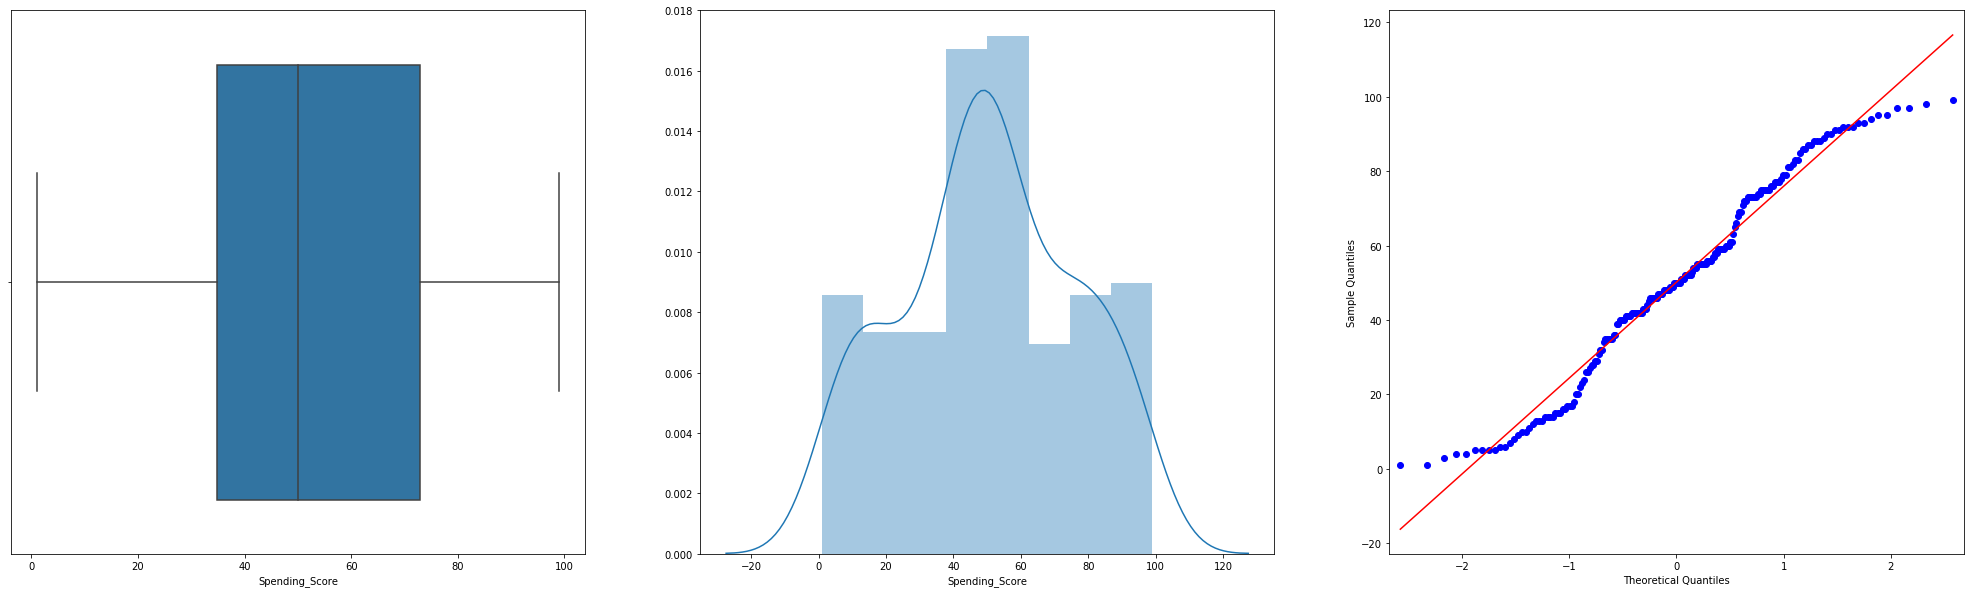

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols =3, figsize =(35,10))
sns.boxplot(df.Spending_Score, ax=ax1)
sns.distplot(df.Spending_Score,ax=ax2)
#add ';' at the end to stop repeating charts. this is a notebook issue.
qqplot(df.Spending_Score, line ='s',ax=ax3);

stat, p = shapiro(df.Spending_Score)
print('Statistics=%.3f, p=%.3f' % (stat, p))

In [8]:
df.Spending_Score.describe()

count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending_Score, dtype: float64

The p-value of the Shapiro-Wilk test is .0002 which rejects the null hypothesis. This means the distribution is normal. Quantile-Quantile (QQ) plots are a visual method to assess the distribution of a dataset. QQ plots compare a dataset's quantiles against a set of normally distributed quantiles. The dataset's quantiles should closely follow the diagonal x=y line. My QQ plot has loose tails but is largely following the x=y line. 

The distribution plot for the Spending Score shows the bins are slightly skewed right which starts near spending score 80. Additionally, the 75% percentile is at spending score 73. I'm not comfortable with selecting 73 as the cutoff score because a strong separation appears at about 80 in the distribution plot. Instead I'm going to cut the difference between the 75% and the visual block at 80 by selecting spending scores at or above the second standard deviation as my target. The second deviation is 76.

In [9]:
sigma=df.Spending_Score.std()
mean= df.Spending_Score.mean()
Twodev= sigma+mean
Twodev

76.02352166837017

In [10]:
df['Target']= np.where(df.Spending_Score<Twodev,0,1)

In [11]:
df.Target.value_counts()

0    164
1     36
Name: Target, dtype: int64

I'm curious to see the distribution of Targets and Non-Targets across both Age and Income. The charts are at different scales which makes the distributions seem to equal in height, but that's not correct. Age seems like a really good predictor and annual income has a slight inverse effect on target/non-target.

Text(0.5, 0, 'Annual Income')

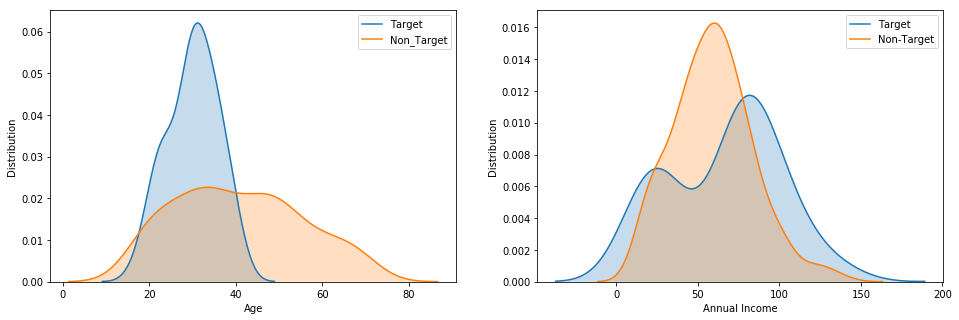

In [12]:
chart=df.drop(["Spending_Score"],axis=1)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(16,5))

sns.kdeplot(chart.Age[chart.Target==1], label='Target', shade=True, ax=ax1)
sns.kdeplot(chart.Age[chart.Target==0], label='Non_Target', shade=True, ax=ax1)
ax1.set_ylabel('Distribution')
ax1.set_xlabel('Age')

sns.kdeplot(chart.Annual_Income[chart.Target==1], label='Target', shade=True, ax=ax2)
sns.kdeplot(chart.Annual_Income[chart.Target==0], label='Non-Target', shade=True, ax=ax2)
ax2.set_ylabel('Distribution')
ax2.set_xlabel('Annual Income')

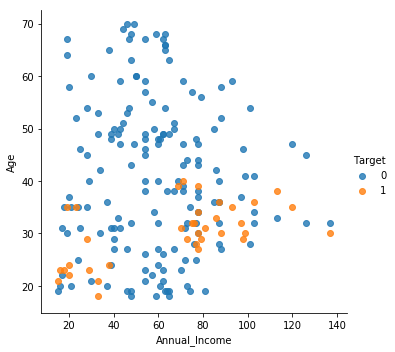

In [13]:
sns.lmplot(x='Annual_Income',y='Age', hue='Target',data=chart,fit_reg=False)

I'm running a supervised classification system for binary data. During my visual inspection of the data I can see the relationships are less linear and therefore perhaps SVM would be the best classification option. SVM will be using my vectors to create a decision boundary between positive and negative outcomes, therefore vector magnitude is relevant. Large distance differences between variables could make significant differences, therefore I'm going to scale the dataset. 

In [14]:
#SCALED
scaler = StandardScaler()
model_df=df.drop(['Target','Spending_Score'],axis=1)
scaled_df= scaler.fit_transform(model_df)
scaled_df=pd.DataFrame(scaled_df)
scaled_df.columns=('Gender','Age','Annual_Income')

#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(scaled_df,
                                                    df['Target'],
                                                    test_size=0.3,
                                                    random_state=100)

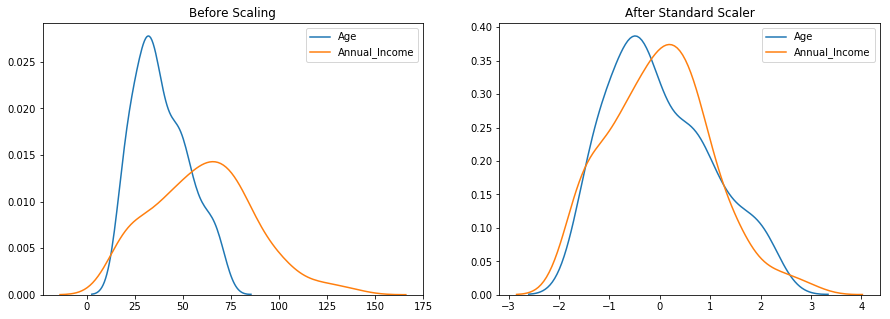

In [15]:
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['Age'], ax=ax1)
sns.kdeplot(df['Annual_Income'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['Age'], ax=ax2)
sns.kdeplot(scaled_df['Annual_Income'], ax=ax2)

Recall earlier that my distribution for the classifier totaled 36 positives and 164 negatives. I'm going to balance this data for a better 50/50 set. SVM works better with a balanced set.

In [16]:
sm = SMOTE(random_state=100)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [17]:
param_grid = {'C': [0.1, 1, 10,100,1000],
              'gamma': [100,10,1,.1,.01], 
              'kernel': ['rbf', 'sigmoid' ]} 
grid_search = GridSearchCV(SVC(),param_grid,refit=True,verbose=1)
grid_search.fit(X_train_res,y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [100, 10, 1, 0.1, 0.01], 'kernel': ['rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [18]:
grid_predictions = grid_search.predict(X_test)
grid_search.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [19]:
print(classification_report(y_test,grid_predictions))
print("Accuracy score: {}".format(accuracy_score(y_test,grid_predictions)))
print("Recall score: {}".format(recall_score(y_test,grid_predictions)))
print("Precision score: {}".format(precision_score(y_test,grid_predictions)))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        45
           1       0.58      0.73      0.65        15

   micro avg       0.80      0.80      0.80        60
   macro avg       0.74      0.78      0.75        60
weighted avg       0.82      0.80      0.81        60

Accuracy score: 0.8
Recall score: 0.7333333333333333
Precision score: 0.5789473684210527


Text(0.5, 1.0, 'Confusion Matrix')

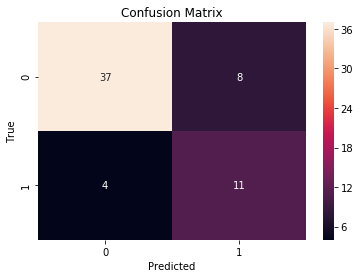

In [20]:
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True); #annot=True to annotate cells
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

I define success for this model in two ways. First, an accurracy score of 80% is successful and meaningful because the model was built on a balanced dataset. Second, the moderate to high recall rate is successful because the model is correctly identifying 73 out of 100 true observations.

I believe my model has demonstrated that sufficient data exists to forecast whether or not a new card holder will later become a top 15% spender.

Ensuring the model is correct would require a randomized control experiement on new card holders, wherein new card holders are randomly assigned to a treatment group or control group. A/B testing with some quantifiable goal, such as the rate of spending score increases, the quantities that treatment vs control are spending, or customer survey feedback could inform the value of this model.